# Calculate Performance Efficiency Rating (PER) with Machine Learning in League of Legends

# Introduction

Riot Games faces the ongoing challenge of accurately evaluating player performance in League of Legends (LoL) to ensure fair matchmaking, balanced gameplay, and accurately rewarding individual gameplay appropriately. Current metrics may not fully capture the nuanced contributions of players in different roles and contexts within the game. This notebook addresses this problem by developing and refining a Player Efficiency Rating (PER) metric that provides a more comprehensive and accurate measure of player performance.

The PER statistic is a comprehensive metric designed to evaluate a player's performance in matches, taking into account various in-game statistics where the model correctly classifies the win/loss outcome of a match 85% of the cases within the test set. The data is comprised of the previous 100 matches of a top ranked player based on the RIOT Leaderboards API and consists of over 45 statistics that are tracked per frame (minute) in the Timeline API. This provides a 

A player's PER to evaluating LoL player performance using advanced data analytics and machine learning techniques. It serves as a valuable tool for researchers, analysts, and enthusiasts aiming to delve deep into the intricacies of player metrics in competitive gaming.


- [Data loading and preprocessing](#data_loading)
- [Raw data exploration](#raw_data)
- [Model training and evaluation](#model_training)
- [Player Efficiency Rating (PER) calculation](#per_calculation)
- [PER data exploration](#per_data)
- [Conclusion](#conclusion)

# 0. Import necessary packages

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

<br>

# 1. Data loading and preprocessing<a id='data_loading'></a>

To achieve our objective, we begin by fetching raw match data from the Riot Games API, which includes details such as player statistics, match timelines, and participant information in North America. This raw data is then processed to extract relevant features, normalize values, and handle any missing or inconsistent entries to ensure that the data is in a structured and clean format, ready for model training. 

Key preprocessing tasks include the extraction of player efficiency ratings (PER), integration of summoner names, and adherence to API rate limits to maintain data integrity and accuracy.

## 1.1 Define API constants

In [69]:
# Define constants
API_KEY = 'RGAPI-bc4a2fca-9e10-4374-8472-3e7bc6452349'
REGION = 'na1'
MATCH_REGION = 'americas'

# Define headers globally
headers = {
    'X-riot-Token': API_KEY
}

## 1.2 Fetch top summoner by id

The top summoners are typically the most skilled and active players in the game, which means their match data is rich and comprehensive. This high-quality data provides a robust foundation for building accurate and reliable predictive models.

By focusing on the top summoners, we can benchmark performance metrics against the best players in the game. This helps in understanding the factors that contribute to high performance and can guide the development of strategies to improve gameplay.

Targeting top summoners also helps manage API rate limits effectively. Since API calls are limited, targeting the most impactful players ensures that the data collected is of the highest value, maximizing the utility of each API request.

*Note: The summoner id is required to extract puuid.*

In [70]:
# Function to fetch top summoner by id
def fetch_top_id():
    challenger_url = f'https://{REGION}.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5/'
    response = requests.get(challenger_url, headers=headers)
    
    challenger_data = response.json()
    
    # Sort data by league points
    sorted_data = sorted(challenger_data['entries'], key=lambda x:x['leaguePoints'], reverse=True)
    
    # Extract top summoner name
    top_summoner = sorted_data[0]
    
    # Extract top summoner id
    top_summoner_id = top_summoner['summonerId'] 
    
    return top_summoner_id

In [71]:
top_id = fetch_top_id()

## 1.3 Fetch top puuid

*Note: The summoner puuid is required to extract match ids.*

In [72]:
# Function to fetch the top summoner's puuid
def fetch_top_puuid(summoner_id):
    summoner_id_url = f'https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}'
    response = requests.get(summoner_id_url, headers=headers)
    
    summoner_data = response.json()
    
    # Extract summoner puuid 
    summoner_puuid = summoner_data['puuid']
    
    return summoner_puuid

In [73]:
top_puuid = fetch_top_puuid(top_id)

## 1.4 Fetch match ids

Match IDs allow us to segment the data into individual matches. This segmentation is crucial for analyzing specific game instances, understanding different game scenarios, and evaluating player performance in varied contexts.

Each match ID serves as a unique identifier to retrieve comprehensive match details, including timelines, player statistics, and events. This detailed data is necessary for in-depth analysis and feature extraction, which are critical for building accurate predictive models.

100 matches are extracted to provide enough data to accurately provide insights into player and team performance.

*Note: The match ids are required to extract match timeline information, as well as match details.*

In [74]:
# Function to fetch match IDs for a given PUUID
def fetch_match_ids(summoner_puuid):
    summoner_match_ids = []
    params = {
        'start': 0,
        'count': 100
    }
    
    matches_url = f'https://{MATCH_REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/{summoner_puuid}/ids'
    response = requests.get(matches_url, headers=headers, params=params)
    
    return response.json()

In [75]:
top_puuid_matches = fetch_match_ids(top_puuid)

## 1.5 Fetch match timeline

The match timeline provides a chronological record of all events that occur during the game, such as kills, deaths, assists, objectives taken, and item purchases based on a given frame (minute). This detailed tracking allows for a granular analysis of player and team behavior throughout the match.

By examining the timeline, we can perform minute-by-minute analysis of the game, enabling us to understand how the game evolves over time. This is essential for identifying key moments, turning points, and trends within a match. 

Key performance metrics like damage dealt, damage taken, healing done, and crowd control applied can also be tracked over time using the timeline. This helps in evaluating the PER of players in various stages of the game.

In [76]:
# Function to fetch match timelines for a given match_id
def fetch_match_timeline(match_id):
    timeline_url = f'https://{MATCH_REGION}.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline'
    response = requests.get(timeline_url, headers=headers)
    
    return response.json()

## 1.6 Fetch match details

Match details provide a complete overview of the game, including participants, their performance, game duration, and final outcome. This comprehensive data is crucial for understanding the context and outcomes of matches.
Player-Specific Information:

Detailed information also includes player information, such as their champion choice, role, items purchased, and final stats (kills, deaths, assists, etc.), is available in the match details. This information is vital for evaluating individual player performance.

In [77]:
# Function to fetch match details that will be used to map various statistics to summoner information
def fetch_match_details(match_id):
    match_details_url = f'https://{MATCH_REGION}.api.riotgames.com/lol/match/v5/matches/{match_id}'
    response = requests.get(match_details_url, headers=headers)
    
    return response.json()

## 1.7 Extract summoner statistics

The extract_stats function is a pivotal component in the data preprocessing pipeline designed for analyzing and modeling player performance in the matches. This function operates by extracting detailed in-game statistics from the timeline data of a match. The timeline data provides a granular view of the game, capturing events and player actions on a minute-by-minute basis.

The primary objective of the extract_stats function is to systematically parse through the timeline data, gather relevant statistics for each player, and compile these into a structured format suitable for further analysis. Key tasks performed by this function include:

In [78]:
def extract_stats(timeline_data):
    stats = []

    # Check if 'info' key is in the timeline data
    if 'info' not in timeline_data:
        print(f"'info' key not found in timeline data")
        return stats

    # Iterate over all frames in the timeline
    for frame_index, frame in enumerate(timeline_data['info']['frames']):
        for frame_id, participant_frame in frame['participantFrames'].items():
            participant_id = participant_frame['participantId']
            if participant_id in participant_id_to_info:
                # Separate championStats and damageStats
                champion_stats = participant_frame.get('championStats', {})
                damage_stats = participant_frame.get('damageStats', {})
                
                # Initialize kills, deaths, and assists
                kills = deaths = assists = 0

                # Check events for kills, deaths, and assists
                if 'events' in frame:
                    for event in frame['events']:
                        if event['type'] == 'CHAMPION_KILL':
                            if event['killerId'] == participant_id:
                                kills += 1
                            if event['victimId'] == participant_id:
                                deaths += 1
                            if participant_id in event.get('assistingParticipantIds', []):
                                assists += 1

                # Combine all stats into a single dictionary
                stat = {
                    'minute': frame_index,
                    'participantId': participant_id,
                    'currentGold': participant_frame.get('currentGold', 0),
                    'totalGold': participant_frame.get('totalGold', 0),
                    'level': participant_frame.get('level', 0),
                    'xp': participant_frame.get('xp', 0),
                    'minionsKilled': participant_frame.get('minionsKilled', 0),
                    'jungleMinionsKilled': participant_frame.get('jungleMinionsKilled', 0),
                    'kills': kills,
                    'deaths': deaths,
                    'assists': assists
                }
                
                # Add all champion stats
                stat.update(champion_stats)
                
                # Add all damage stats
                stat.update(damage_stats)
                
                # Add PUUID, championName, and win/loss to the stat entry
                info = participant_id_to_info.get(participant_id, {'puuid': 'unknown', 'championName': 'unknown', 'win': 'unknown'})
                stat['puuid'] = info['puuid']
                stat['championName'] = info['championName']
                stat['win'] = info['win']
                
                stats.append(stat)

    return stats

In [79]:
# Dictionary to store participant frames with minutes for each match
frames_by_match = {}

In [80]:
# Set to keep track of processed match IDs
processed_match_ids = set()

## 1.8 Match data processing loop

The goal is to construct a comprehensive dataset that captures minute-by-minute participant statistics and in-game events, enabling deep analysis and model development. The following loop utilizes the functions above to create a dictionary of summoner statistics while adhering to Riot's API request limitations.

In [81]:
# Fetch timeline data and extract participant frames with minutes for each match
for match_id in top_puuid_matches:
    if match_id in processed_match_ids:
        print(f'Match ID {match_id} already processed. Skipping.')
        continue

    match_details = fetch_match_details(match_id)
    
    # Create a mapping of participantId to PUUID, championName, and win/loss
    participant_id_to_info = {}
    for participant in match_details['info']['participants']:
        participant_id_to_info[participant['participantId']] = {
            'puuid': participant['puuid'],
            'championName': participant['championName'],
            'win': 1 if participant['win'] else 0
        }
    
    timeline_data = fetch_match_timeline(match_id)
    stats = extract_stats(timeline_data)
    
    frames_by_match[match_id] = {
        'stats': stats
    }

    # Mark this match as processed
    processed_match_ids.add(match_id)

    # Respect Riot API rate limits
    time.sleep(1.2)  # Adding a delay to avoid rate limit issues

## 1.9 Prepare dictionary for DataFrame creation

In [82]:
# Flatten the dictionary into a list of records for the DataFrame
records = []
for match_id, data in frames_by_match.items():
    for stat in data['stats']:
        record = {'match_id': match_id}
        record.update(stat)
        records.append(record)

In [83]:
# Convert the list of records into a DataFrame
df = pd.DataFrame(records)

## 1.10 Save raw data to CSV

In [84]:
# Save the DataFrame to a CSV file
output_file = 'stats_by_top_summoner.csv'
df.to_csv(output_file, index=False)

<br>

# 2. Raw data exploration <a id='raw_data'></a>

## 2.1 Data overview

In [85]:
df = pd.read_csv('stats_by_top_summoner.csv')

In [86]:
# Display the first 5 rows of the dataframe to understand its structure
df.head()

match_id  minute  participantId  currentGold  totalGold  level  xp  \
0  NA1_5049486724       0              1          500        500      1   0   
1  NA1_5049486724       0              2          500        500      1   0   
2  NA1_5049486724       0              3          500        500      1   0   
3  NA1_5049486724       0              4          500        500      1   0   
4  NA1_5049486724       0              5          500        500      1   0   

   minionsKilled  jungleMinionsKilled  kills  ...  physicalDamageTaken  \
0              0                    0      0  ...                    0   
1              0                    0      0  ...                    0   
2              0                    0      0  ...                    0   
3              0                    0      0  ...                    0   
4              0                    0      0  ...                    0   

   totalDamageDone  totalDamageDoneToChampions  totalDamageTaken  \
0                0                           0                 0   
1                0                           0                 0   
2                0                           0                 0   
3                0                           0                 0   
4                0                           0                 0   

   trueDamageDone  trueDamageDoneToChampions  trueDamageTaken  \
0               0                          0                0   
1               0                          0                0   
2               0                          0                0   
3               0                          0                0   
4               0                          0                0   

                                               puuid  championName  win  
0  _hyiLYl2jB2mtTsyDODDDW0mzy7LbLy7Pannu1f1xnh_36...        Yorick    1  
1  2s0lwB22aG3lfmHmnHPfHrduKx07eSMpXONbtoxzwwbl9n...         Janna    1  
2  DmS21Uzx2p5IKrb-tjDYTYyremMzo0-WK9EOpZqpABqszr...        Draven    1  
3  JwvLpy9x_fT1DZNQaNz1t28KWWDVDO1WXCWVB-yV8PugGR...           Zac    1  
4  zmRffKt64BgFCVj7_WoINp5EwPu6asA1MPasbrhUH4TaAc...         Garen    1  

[5 rows x 52 columns]

In [87]:
# Dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25090 entries, 0 to 25089
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   match_id                       25090 non-null  object
 1   minute                         25090 non-null  int64 
 2   participantId                  25090 non-null  int64 
 3   currentGold                    25090 non-null  int64 
 4   totalGold                      25090 non-null  int64 
 5   level                          25090 non-null  int64 
 6   xp                             25090 non-null  int64 
 7   minionsKilled                  25090 non-null  int64 
 8   jungleMinionsKilled            25090 non-null  int64 
 9   kills                          25090 non-null  int64 
 10  deaths                         25090 non-null  int64 
 11  assists                        25090 non-null  int64 
 12  abilityHaste                   25090 non-null  int64 
 13  a

In [88]:
# Summary statistics
df.describe(include='all')

match_id        minute  participantId   currentGold  \
count            25090  25090.000000   25090.000000  25090.000000   
unique             100           NaN            NaN           NaN   
top     NA1_5043906366           NaN            NaN           NaN   
freq               480           NaN            NaN           NaN   
mean               NaN     12.324033       5.994540    673.102471   
std                NaN      8.491610       3.425015    626.153314   
min                NaN      0.000000       1.000000      0.000000   
25%                NaN      5.000000       3.000000    250.000000   
50%                NaN     11.000000       6.000000    500.000000   
75%                NaN     18.000000       8.000000    930.000000   
max                NaN     47.000000      16.000000   8367.000000   

           totalGold         level            xp  minionsKilled  \
count   25090.000000  25090.000000  25090.000000   25090.000000   
unique           NaN           NaN           NaN            NaN   
top              NaN           NaN           NaN            NaN   
freq             NaN           NaN           NaN            NaN   
mean     5973.802790      9.291829   7267.917098      47.908649   
std      4311.810059      4.828161   5612.903955     134.678313   
min         0.000000      1.000000      0.000000       0.000000   
25%      2277.000000      5.000000   2542.000000       0.000000   
50%      5249.000000      9.000000   6109.000000      15.000000   
75%      8800.750000     13.000000  11000.000000      59.000000   
max     25655.000000     33.000000  35341.000000    5782.000000   

        jungleMinionsKilled         kills  ...  physicalDamageTaken  \
count          25090.000000  25090.000000  ...         25090.000000   
unique                  NaN           NaN  ...                  NaN   
top                     NaN           NaN  ...                  NaN   
freq                    NaN           NaN  ...                  NaN   
mean              10.064488      0.281786  ...          6377.304344   
std               32.453165      0.634600  ...          6277.014188   
min                0.000000      0.000000  ...             0.000000   
25%                0.000000      0.000000  ...          1482.000000   
50%                0.000000      0.000000  ...          4613.000000   
75%                0.000000      0.000000  ...          9484.250000   
max              267.000000      7.000000  ...         51758.000000   

        totalDamageDone  totalDamageDoneToChampions  totalDamageTaken  \
count      2.509000e+04                 25090.00000      25090.000000   
unique              NaN                         NaN               NaN   
top                 NaN                         NaN               NaN   
freq                NaN                         NaN               NaN   
mean       5.011200e+04                  9399.32774      11246.929813   
std        1.570138e+05                 10640.96113      11143.352731   
min        0.000000e+00                     0.00000          0.000000   
25%        7.216000e+03                  1707.00000       2535.250000   
50%        2.344650e+04                  5727.50000       8072.000000   
75%        6.208025e+04                 13412.00000      16906.750000   
max        1.052622e+07                 89855.00000     115708.000000   

        trueDamageDone  trueDamageDoneToChampions  trueDamageTaken  \
count     2.509000e+04               25090.000000     25090.000000   
unique             NaN                        NaN              NaN   
top                NaN                        NaN              NaN   
freq               NaN                        NaN              NaN   
mean      6.394402e+03                 585.229215       637.471064   
std       2.371720e+04                1428.260655      1231.690185   
min       0.000000e+00                   0.000000         0.000000   
25%       0.000000e+00                   0.000000        28.000000   
50%       8.600000e+

In [89]:
# Missing values
df.isna().sum()

match_id                         0
minute                           0
participantId                    0
currentGold                      0
totalGold                        0
level                            0
xp                               0
minionsKilled                    0
jungleMinionsKilled              0
kills                            0
deaths                           0
assists                          0
abilityHaste                     0
abilityPower                     0
armor                            0
armorPen                         0
armorPenPercent                  0
attackDamage                     0
attackSpeed                      0
bonusArmorPenPercent             0
bonusMagicPenPercent             0
ccReduction                      0
cooldownReduction                0
health                           0
healthMax                        0
healthRegen                      0
lifesteal                        0
magicPen                         0
magicPenPercent     

## 2.2 Target variable analysis

In [90]:
# Count the number of wins and losses
win_count = df['win'].sum()  # Assuming 'win' column has 1 for wins and 0 for losses
loss_count = len(df) - win_count

# Calculate the total number of games
total_games = len(df)

# Compute the percentage of wins
percent_wins = (win_count / total_games) * 100

# Print the results
print(f"Number of Wins: {win_count}")
print(f"Number of Losses: {loss_count}")
print(f"Percentage of Wins: {percent_wins:.2f}%")

Number of Wins: 12546
Number of Losses: 12544
Percentage of Wins: 50.00%


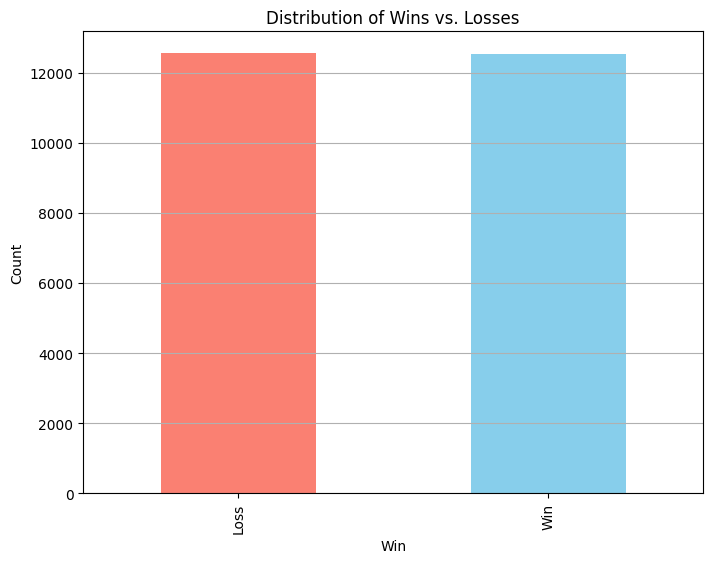

In [134]:
# Plotting the distribution of the target variable 'win'
win_counts = df['win'].value_counts()

plt.figure(figsize=(8, 6))
win_counts.plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Distribution of Wins vs. Losses')
plt.xlabel('Win')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Loss', 'Win'])
plt.grid(axis='y')

plt.show();

Interpretation:
- Win and loss rates are extremely similar

## 2.3 Time series analysis

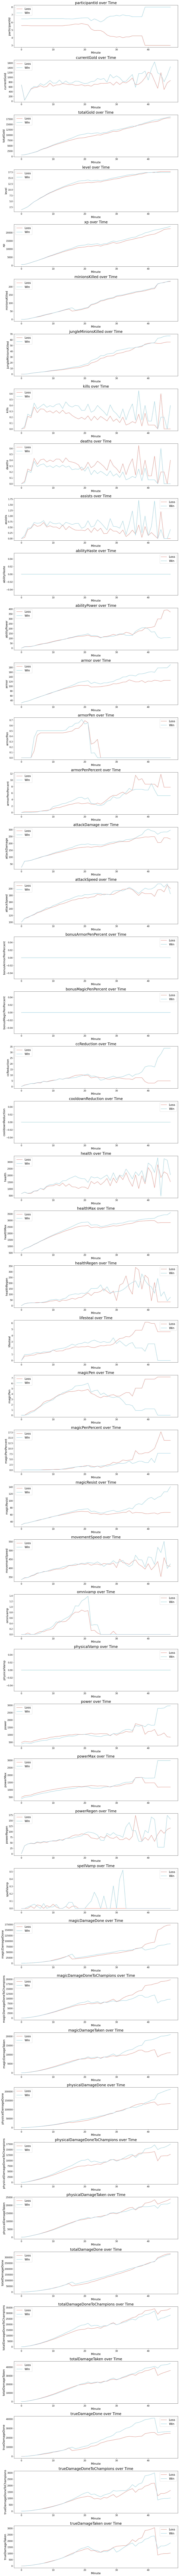

In [135]:
# Extract all numeric key_time_features from the data
numeric_key_time_features = df.select_dtypes(include=['number']).columns.tolist()
numeric_key_time_features = [feature for feature in numeric_key_time_features if feature not in ['win', 'minute']]

# Plotting key statistics over time for wins and losses
plt.figure(figsize=(14, 200))

for i, feature in enumerate(numeric_key_time_features, 1):
    plt.subplot(len(numeric_key_time_features), 1, i)
    for outcome in [0, 1]:
        subset = df[df['win'] == outcome]
        avg_feature_per_minute = subset.groupby('minute')[feature].mean()
        plt.plot(avg_feature_per_minute.index, avg_feature_per_minute, label='Loss' if outcome == 0 else 'Win', 
                 color='salmon' if outcome == 0 else 'skyblue')
    
    plt.title(f'{feature} over Time', fontsize=20)
    plt.xlabel('Minute', fontsize=16)
    plt.ylabel(feature, fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=16)

plt.tight_layout()
plt.show();

Interpretations:
- kills over time
    - Higher kills per minute lead to an increased chance of winning
- deaths over time
    - Higher deaths per minute lead to an increased chance of losing
- assists over time
    - Spikes in late game assists appear to be due to team wipes based on minute
- armorPen over time
    - armorPen items are sold around the 25-minute mark
- lifesteal over time
    - lifesteal purchases increased in losing teams around the 30-minute mark
- magicPen over time
    - magicPen items begin to be sold starting at the 20-minute mark and drastically drop around the 30-minute mark for winning teams
- magicResist over time
    - Winning teams invest in magicResist during the late game
- omnivamp over time
    - omnivamp items are sold by both teams around the 20-minute mark
- trueDamageDone
    - trueDamageDone increases in wins at a higher rate than compared to losses

## 2.4 Champion distribution

In [93]:
# Extracting the top 10 played champion names
top_champion_frequencies = df['championName'].value_counts().head(10)

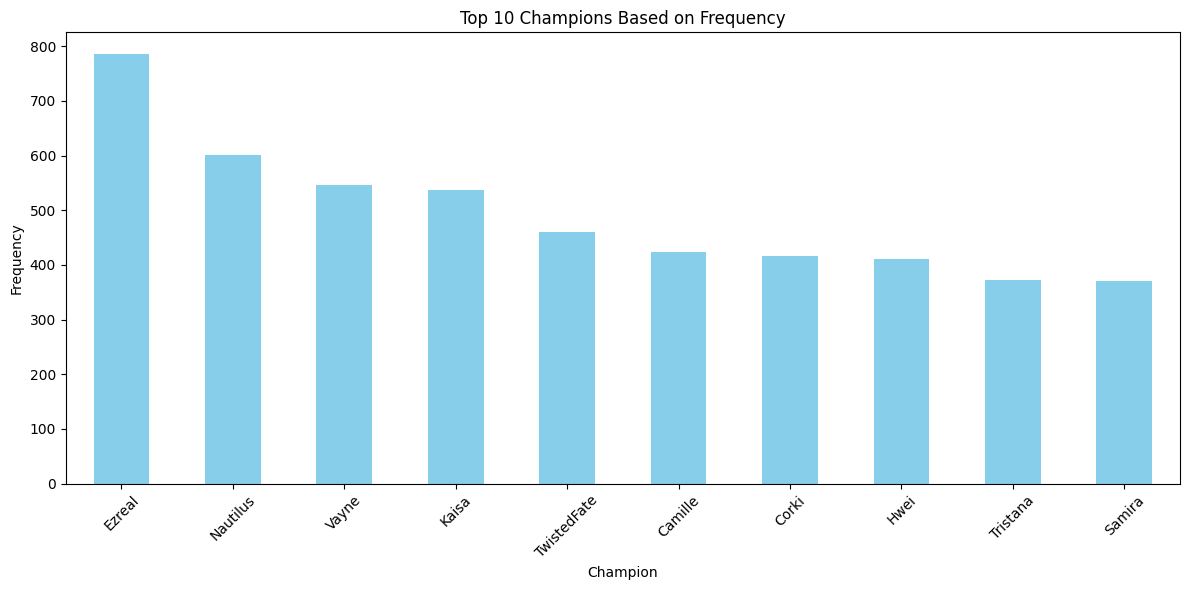

In [94]:
plt.figure(figsize=(12, 6))
top_champion_frequencies.plot(kind='bar', color='skyblue')
plt.title('Top 10 Champions Based on Frequency')
plt.xlabel('Champion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

Interpretation:
- Ezreal is the most played champion in the dataset.

In [95]:
# Extracting the top 10 played champion names
bot_champion_frequencies = df['championName'].value_counts().tail(10)

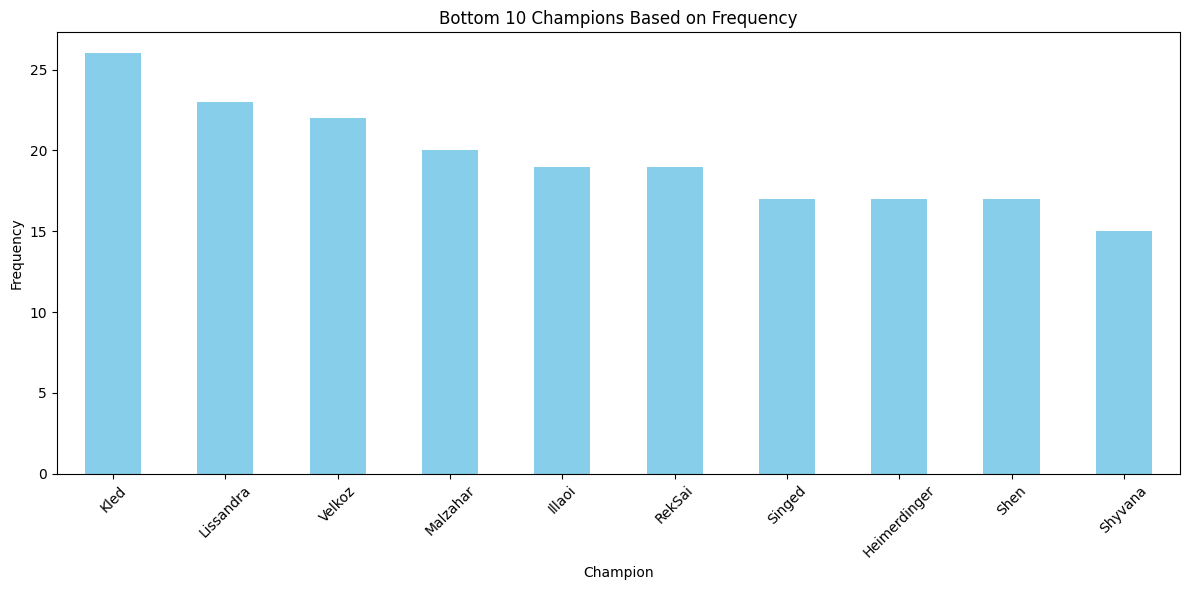

In [96]:
plt.figure(figsize=(12, 6))
bot_champion_frequencies.plot(kind='bar', color='skyblue')
plt.title('Bottom 10 Champions Based on Frequency')
plt.xlabel('Champion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

Interpretation:
- Shyvana is the least played champion in the dataset.

## 2.5 Correlation heatmap

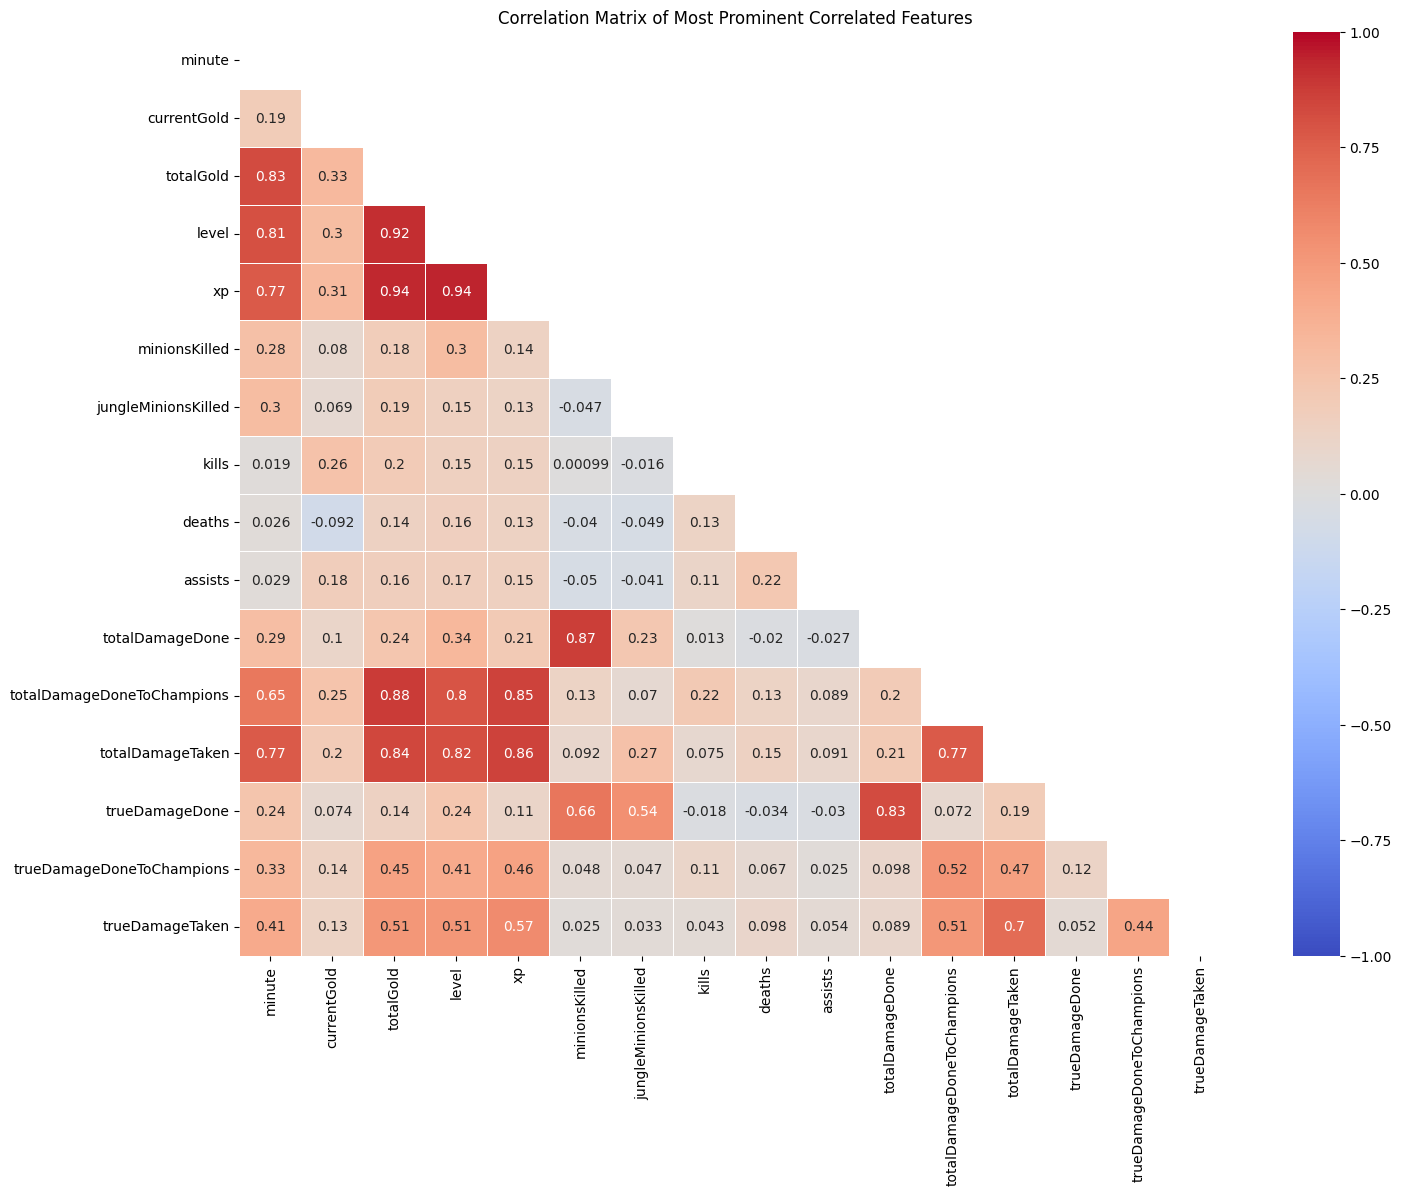

In [97]:
# List of features to generate a correlation matrix for
features_corr = [
    'minute', 'currentGold', 'totalGold', 'level', 'xp', 'minionsKilled',
    'jungleMinionsKilled', 'kills', 'deaths', 'assists', 
    'totalDamageDone', 'totalDamageDoneToChampions',
    'totalDamageTaken', 'trueDamageDone', 'trueDamageDoneToChampions',
    'trueDamageTaken'
]

# Create correlations using the specified features
prominent_correlations = df[features_corr].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(prominent_correlations, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Draw the heatmap
sns.heatmap(prominent_correlations, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)

# Display the plot
plt.title('Correlation Matrix of Most Prominent Correlated Features')
plt.show();

Interpretations:
<br>
Aside from the self-explanatory relationship between level, xp, and totalGold the following interpretations can be extracted from the matrix.
- totalDamageTaken
    - Active participation in battles lead to higher accumulations of totalGold, level, and xp
- kills 
    - The importance of kills is less significant than other features
    

<br>

# 3. Model training and evaluation <a id='model_training'></a>

## 3.1 Extract training statistics

In [98]:
# Extract statistics to be used as features in training 
stats_features = df[['currentGold', 'totalGold', 'level', 'xp', 'minionsKilled', 'jungleMinionsKilled', 'kills',
                     'deaths', 'assists', 'abilityPower', 'abilityHaste', 'armor', 'armorPen', 'armorPenPercent',
                     'attackDamage', 'attackSpeed', 'bonusArmorPenPercent', 'bonusMagicPenPercent', 'ccReduction',
                     'cooldownReduction', 'health', 'healthMax', 'healthRegen', 'lifesteal', 'magicPen',
                     'magicPenPercent', 'magicResist', 'movementSpeed', 'omnivamp', 'physicalVamp', 'power',
                     'powerMax', 'powerRegen', 'spellVamp', 'magicDamageDone', 'magicDamageDoneToChampions',
                     'magicDamageTaken', 'physicalDamageDone', 'physicalDamageDoneToChampions', 'physicalDamageTaken',
                     'totalDamageDone', 'totalDamageDoneToChampions', 'totalDamageTaken', 'trueDamageDone',
                     'trueDamageDoneToChampions', 'trueDamageTaken']]

## 3.2 Extract target variable

In [99]:
# Define the target variable for the model
target = df['win']

## 3.3 Create train-test split

In [100]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(stats_features, target, test_size=0.3, random_state=42)

## 3.4 Define parameter distribution

In [101]:
# Define the parameter distribution for the RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}

## 3.5 Initialize XGBoost classifier

In [102]:
# Initialize the XGBoost classifier
xgb_model_tuned = XGBClassifier(random_state=42, use_label_encoder=False)

## 3.6 Perform randomized search and fit

In [103]:
# Perform a randomized search over the parameter grid
random_search = RandomizedSearchCV(estimator=xgb_model_tuned, param_distributions=param_dist, 
                                   n_iter=100, scoring='accuracy', cv=3, verbose=1, n_jobs=-1, random_state=42)

# Fit the model to the training data
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [50, 100, 200, 300],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [0, 0.01, 0.1, 1],
                                        'subsample': [0.6, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

## 3.7 Best parameters and score

In [104]:
# Retrieve the best parameters and the best score from the random search
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

# Print the best parameters and the best cross-validation accuracy
print(f"Best Parameters: {best_params_random}")
print(f"Best Cross-Validation Accuracy: {best_score_random}")

Best Parameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9}
Best Cross-Validation Accuracy: 0.8002052700735449


## 3.8 Train the XGBoost model

In [105]:
# Train the XGBoost model with the best parameters on the training data
best_xgb_model = XGBClassifier(**best_params_random, random_state=42, use_label_encoder=False)
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## 3.9 Create predictions

In [106]:
# Predict on the test set with the trained model
y_pred_best = best_xgb_model.predict(X_test)

## 3.10 Prediction accuracy

In [107]:
# Calculate the accuracy of the predictions
accuracy_best = accuracy_score(y_test, y_pred_best)

## 3.11 Confusion matrix

In [108]:
# Generate the confusion matrix for the predictions
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

## 3.12 Model evaluation

In [109]:
# Print the test set accuracy and the confusion matrix
print(f"Test Set Accuracy: {accuracy_best}")
print(f"Confusion Matrix: \n{conf_matrix_best}")

Test Set Accuracy: 0.8395110933971037
Confusion Matrix: 
[[3145  568]
 [ 640 3174]]


<br>

# 4. Player Efficiency Rating (PER) calculation <a id='per_calculation'></a>

The process of creating the PER metric involves normalizing the relevant features, applying appropriate weights, and creating a new PER feature within the DataFrame.

We start by computing the PER stat for each player. This involves summing the products of normalized features and their corresponding weights. The normalization ensures that each feature contributes proportionately to the PER, and the weights reflect the relative importance of each feature.

*Note: To enhance readability and consistency, the calculated PER values are multiplied by 100 and rounded to the second decimal place. These steps ensures that the PER values are presented in a standardized format, making them easier to analyze and compare.*

## 4.1 Extract feature importances

In [110]:
# Get the feature importances from the trained model
feature_importances_best = best_xgb_model.feature_importances_

In [111]:
# Create a DataFrame to display feature importances sorted by importance
feature_importances_df = pd.DataFrame({'Feature': stats_features.columns, 
                                       'Importance': feature_importances_best}).sort_values('Importance', ascending=False)

# Display dataframe
feature_importances_df

Feature  Importance
7                          deaths    0.089203
6                           kills    0.053115
8                         assists    0.042725
5             jungleMinionsKilled    0.035692
2                           level    0.035433
12                       armorPen    0.033618
23                      lifesteal    0.031999
1                       totalGold    0.030626
24                       magicPen    0.027593
18                    ccReduction    0.026442
4                   minionsKilled    0.026279
44      trueDamageDoneToChampions    0.025381
45                trueDamageTaken    0.023785
11                          armor    0.022785
41     totalDamageDoneToChampions    0.022190
9                    abilityPower    0.022181
3                              xp    0.022132
25                magicPenPercent    0.021612
43                 trueDamageDone    0.021531
39            physicalDamageTaken    0.021531
21                      healthMax    0.021212
42               totalDamageTaken    0.021034
35     magicDamageDoneToChampions    0.020306
40                totalDamageDone    0.020235
14                   attackDamage    0.020059
26                    magicResist    0.020034
34                magicDamageDone    0.019803
20                         health    0.019687
36               magicDamageTaken    0.019624
31                       powerMax    0.019552
22                    healthRegen    0.019199
15                    attackSpeed    0.019198
37             physicalDamageDone    0.018608
38  physicalDamageDoneToChampions    0.018027
27                  movementSpeed    0.017729
32                     powerRegen    0.016597
13                armorPenPercent    0.016314
30                          power    0.015001
0                     currentGold    0.013355
28                       omnivamp    0.008574
33                      spellVamp    0.000000
10                   abilityHaste    0.000000
19              cooldownReduction    0.000000
17           bonusMagicPenPercent    0.000000
16           bonusArmorPenPercent    0.000000
29                   physicalVamp    0.000000

## 4.2 Convert importances to weights

In [112]:
# Convert the dataframe to a dictionary where the keys are feature names and the values are their importance scores
feature_weights = pd.Series(feature_importances_df.Importance.values, index=feature_importances_df.Feature).to_dict()

## 4.3 Extract statistics features

In [113]:
# Filter the 0th minute of each game to avoid missing values and incorrectly calculating PER 
df_filtered = df[df['minute'] != 0 ].dropna(axis=1)

# Select stat features to be filtered from non-stat dataframe 
stats_features_cols = stats_features.columns

# Select columns that are not in stats_features_cols
df_non_stats = df_filtered.loc[:, ~df_filtered.columns.isin(stats_features_cols)]

# Remove columns with all zero values
df_filtered_no_zeros = df_filtered.loc[:, (df_filtered != 0).any(axis=0)]

# Filter feature_weights to include only columns present in df_stats_no_zeros
valid_features = [feature for feature in feature_weights.keys() if feature in df_filtered_no_zeros.columns]
filtered_feature_weights = {feature: feature_weights[feature] for feature in valid_features}

# List of stats features used for normalization
all_features = pd.DataFrame(df_filtered_no_zeros, columns=valid_features)

## 4.4 Normalize weights

In [114]:
# Normalize the weights to ensure they sum to 1
total_weight = sum(filtered_feature_weights.values())
weights = {k: v / total_weight for k, v in filtered_feature_weights.items()}

## 4.5 Normalize features

In [115]:
# Normalize the features (min-max normalization for simplicity)
df_normalized = df_filtered_no_zeros.copy()
df_normalized[all_features.columns] = (df_normalized[all_features.columns] - df_normalized[all_features.columns].min()) / (df_normalized[all_features.columns].max() - df_normalized[all_features.columns].min())

## 4.6 Calculate PER

In [116]:
# Calculate the PER stat and add the feature to the df_filtered_no_zeros dataframe
df_filtered_no_zeros['per'] = sum(df_normalized[feature] * weight for feature, weight in filtered_feature_weights.items()) * 100

# Round the new feature to the second decimal place
df_filtered_no_zeros['per'] = df_filtered_no_zeros['per'].round(2)

# Copy the df_filtered_no_zeros to a new dataframe
df_per = df_filtered_no_zeros.copy()

# Display the DataFrame with the PER-like stat
df_per

C:\Users\josht\AppData\Local\Temp\ipykernel_22520\1942265983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_no_zeros['per'] = sum(df_normalized[feature] * weight for feature, weight in filtered_feature_weights.items()) * 100
C:\Users\josht\AppData\Local\Temp\ipykernel_22520\1942265983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_no_zeros['per'] = df_filtered_no_zeros['per'].round(2)


match_id  minute  participantId  currentGold  totalGold  level  \
10     NA1_5049486724       1              1            0        500      1   
11     NA1_5049486724       1              2            0        500      1   
12     NA1_5049486724       1              3            0        500      1   
13     NA1_5049486724       1              4           50        500      1   
14     NA1_5049486724       1              5            0        500      1   
...               ...     ...            ...          ...        ...    ...   
25085  NA1_5023207728      23              6         1059      11554     14   
25086  NA1_5023207728      23              7         1843      14522     15   
25087  NA1_5023207728      23              8         1547       8592     12   
25088  NA1_5023207728      23              9         1172       9767     14   
25089  NA1_5023207728      23             10         1154       8009     11   

          xp  minionsKilled  jungleMinionsKilled  kills  ...  totalDamageDone  \
10         0              0                    0      0  ...                0   
11         0              0                    0      0  ...                0   
12         0              0                    0      0  ...                0   
13         0              0                    0      0  ...                0   
14         0              0                    0      0  ...                0   
...      ...            ...                  ...    ...  ...              ...   
25085  12862            192                    8      0  ...           129105   
25086  14485             21                  166      1  ...           256313   
25087   9736            146                    0      0  ...            82792   
25088  12199            199                    6      1  ...           118257   
25089   8105             25                    0      0  ...            16844   

       totalDamageDoneToChampions  totalDamageTaken  trueDamageDone  \
10                              0                 0               0   
11                              0                 0               0   
12                              0                 0               0   
13                              0                 0               0   
14                              0                 0               0   
...                           ...               ...             ...   
25085                       13586             19761            5128   
25086                       27770             20262           64332   
25087                        9797             17818            2534   
25088                       18551             13582             753   
25089                        6829             14529            6864   

       trueDamageDoneToChampions  trueDamageTaken  \
10                             0                0   
11                             0                0   
12                             0                0   
13                             0                0   
14                             0                0   
...                          ...              ...   
25085                       2970               65   
25086                       1838               25   
25087                         78               65   
25088                        146               25   
25089                        963               75   

                                                   puuid  championName  win  \
10     _hyiLYl2jB2mtTsyDODDDW0mzy7LbLy7Pannu1f1xnh_36...        Yorick    1   
11     2s0lwB22aG3lfmHmnHPfHrduKx07eSMpXONbtoxzwwbl9n...         Janna    1   
12     DmS21Uzx2p5IKrb-tjDYTYyremMzo0-WK9EOpZqpABqszr...        Draven    1   
13     JwvLpy9x_fT1DZNQaNz1t28KWWDVDO1WXCWVB-yV8PugGR...           Zac    1   
14     zmRffKt64BgFCVj7_WoINp5EwPu6asA1MPasbrhUH4TaAc...         Garen    1   
...                                                  ...           ...  ...   
25085  Kiez-bP2xLzoL-bB_xJy7JcewQd3mVGJn7TwTDWV2

## 4.7 Save PER data to CSV

In [117]:
# Save the DataFrame to a CSV file
output_file = 'stats_by_top_summoner_PER.csv'
df_per.to_csv(output_file, index=False)

<br>

# 5. PER data exploration <a id='per_data'></a>

## 5.1 PER data overview

In [118]:
df_per = pd.read_csv('stats_by_top_summoner_PER.csv')

In [119]:
df_per['per'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 24034 entries, 0 to 24033
Series name: per
Non-Null Count  Dtype  
--------------  -----  
24034 non-null  float64
dtypes: float64(1)
memory usage: 187.9 KB


In [120]:
df_per['per'].describe()

count    24034.000000
mean         9.473143
std          4.986751
min          1.740000
25%          5.290000
50%          9.090000
75%         12.950000
max         32.340000
Name: per, dtype: float64

## 5.2 Distribution of PER scores (last minute)

In [121]:
# Define the function to obtain the rows from max minute of each match for each participant
def last_min_filter(df):
    # Group by match_id and participantId, then get the row with the maximum minute for each group
    last_min_rows = df.loc[df.groupby(['match_id', 'participantId'])['minute'].idxmax()]
    return last_min_rows

# Apply the function to the per dataset
last_min_df_per = last_min_filter(df_per)

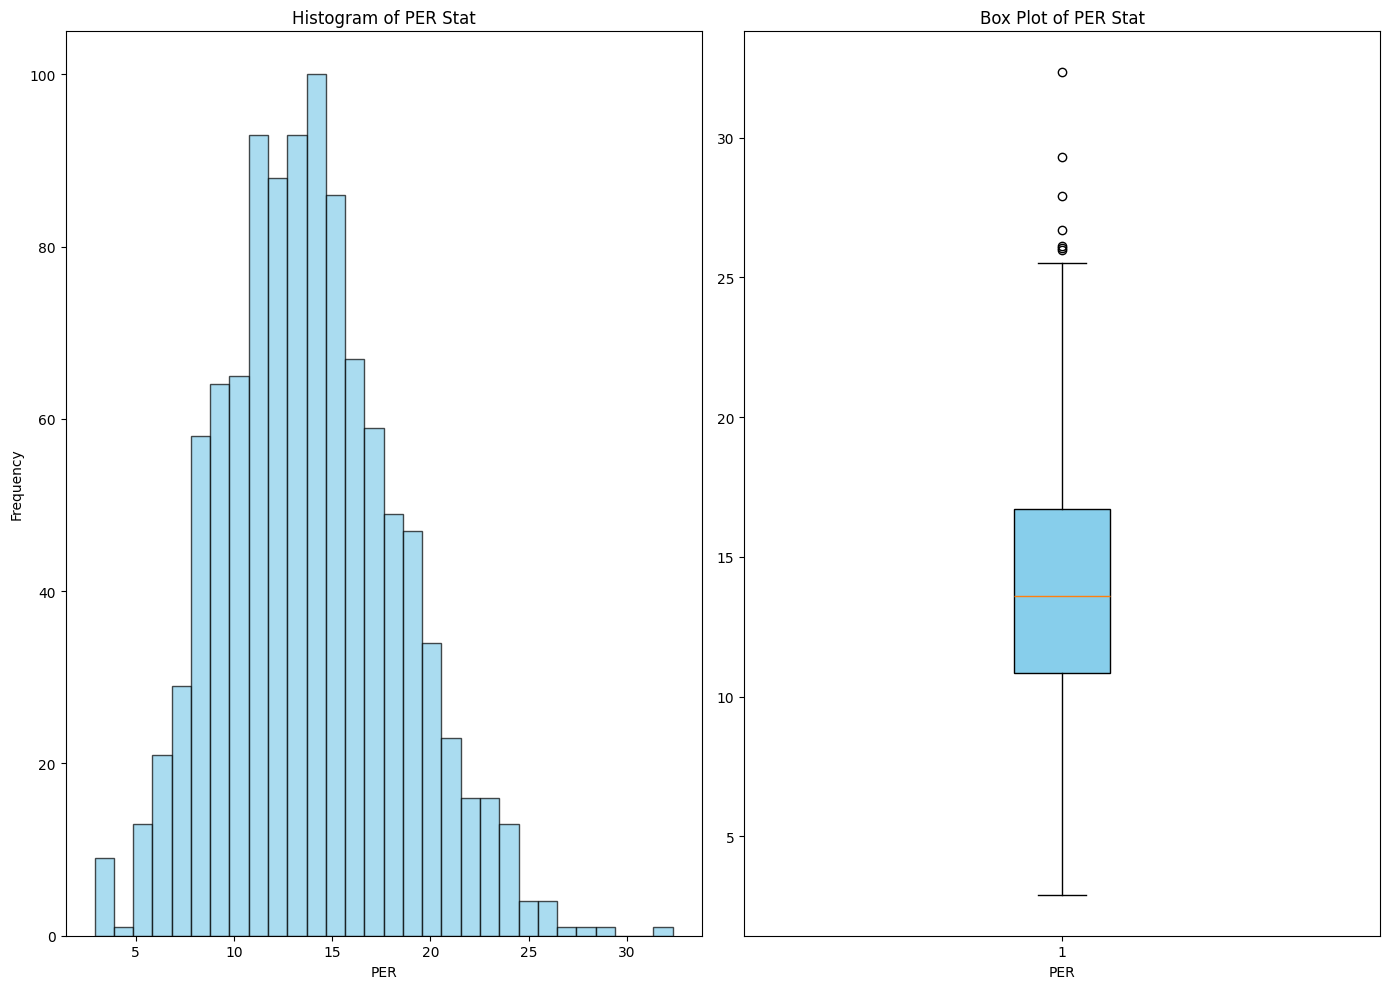

In [122]:
# Create a combined plot with a histogram and box plot for the 'per' stat
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# Histogram
axs[0].hist(last_min_df_per['per'], bins=30, edgecolor='k', alpha=0.7, color='skyblue')
axs[0].set_title('Histogram of PER Stat')
axs[0].set_xlabel('PER')
axs[0].set_ylabel('Frequency')
axs[0].grid(False)

# Box plot
box = axs[1].boxplot(last_min_df_per['per'], vert=True, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('skyblue')

axs[1].set_title('Box Plot of PER Stat')
axs[1].set_xlabel('PER')
axs[1].grid(False)

# Adjust layout
plt.tight_layout()
plt.show();

Interpretations:
- The histogram shows that the distribution of the 'PER' stat is slightly skewed to the right, with most values concentrated between 5 and 20.
- The interquartile range (IQR), represented by the length of the box in the box plot, shows the middle 50% of the data, ranging from approximately 10 to 17.

## 5.3 Top 10 champions based on AVERAGE PER 

In [123]:
# Calculate the average 'per' for each champion
average_per_by_champion = df_per.groupby('championName')['per'].mean().sort_values(ascending=False).head(10)

# Extract the top 10 champions
top_10_champions = average_per_by_champion.index.tolist()

# Filter the data for the top 10 champions
top_10_data = df_per[df_per['championName'].isin(top_10_champions)]

# Calculate the average 'per' for the top 10 champions
average_per_top_10 = top_10_data.groupby('championName')['per'].mean().sort_values(ascending=False)

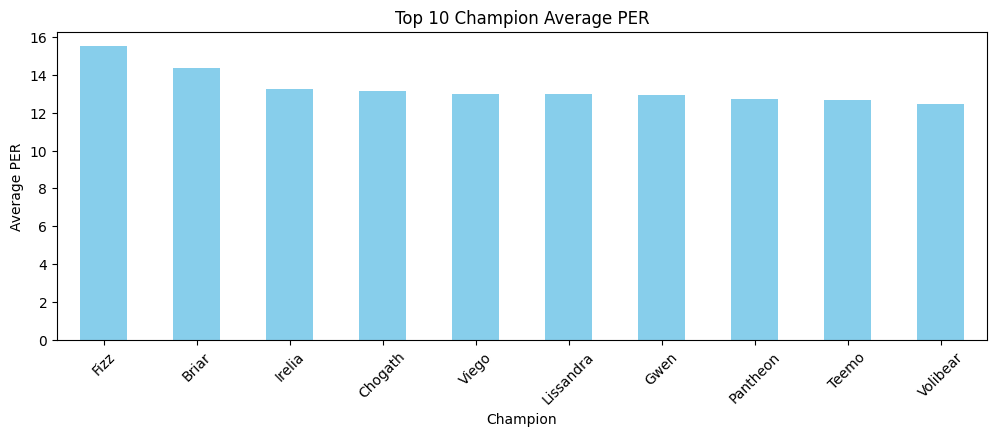

In [124]:
# Create a bar chart for the average 'per' of the top 10 champions
fig, ax = plt.subplots(figsize=(12, 4))
average_per_top_10.plot(kind='bar', color='skyblue', ax=ax)

ax.set_title('Top 10 Champion Average PER')
ax.set_xlabel('Champion')
ax.set_ylabel('Average PER')
plt.xticks(rotation=45)
plt.show();

## 5.4 Top 10 champions based on HIGHEST PER

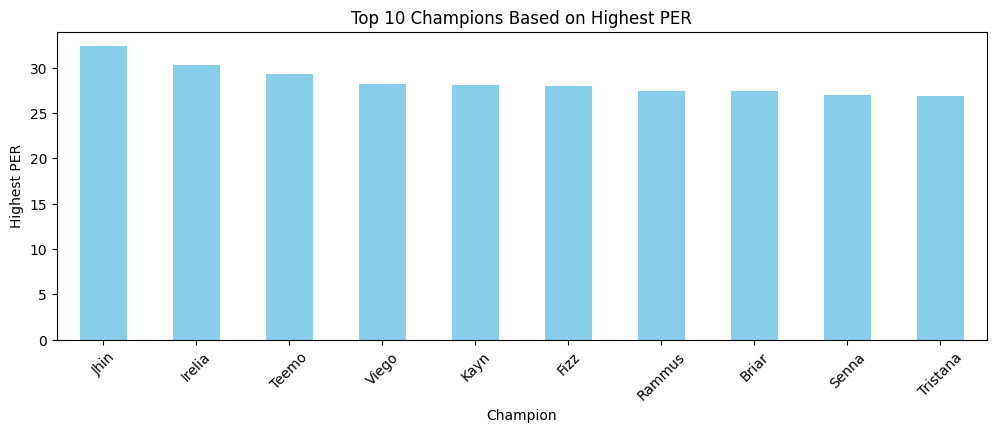

In [125]:
# Identify the highest 'per' value for each champion
highest_per_by_champion = df_per.groupby('championName')['per'].max().sort_values(ascending=False).head(10)

# Create a bar chart for the highest 'per' of the top 10 champions
fig, ax = plt.subplots(figsize=(12, 4))
highest_per_by_champion.plot(kind='bar', color='skyblue', ax=ax)

ax.set_title('Top 10 Champions Based on Highest PER')
ax.set_xlabel('Champion')
ax.set_ylabel('Highest PER')
plt.xticks(rotation=45)
plt.show();

## 5.5 Top 10 champions based on LOWEST PER

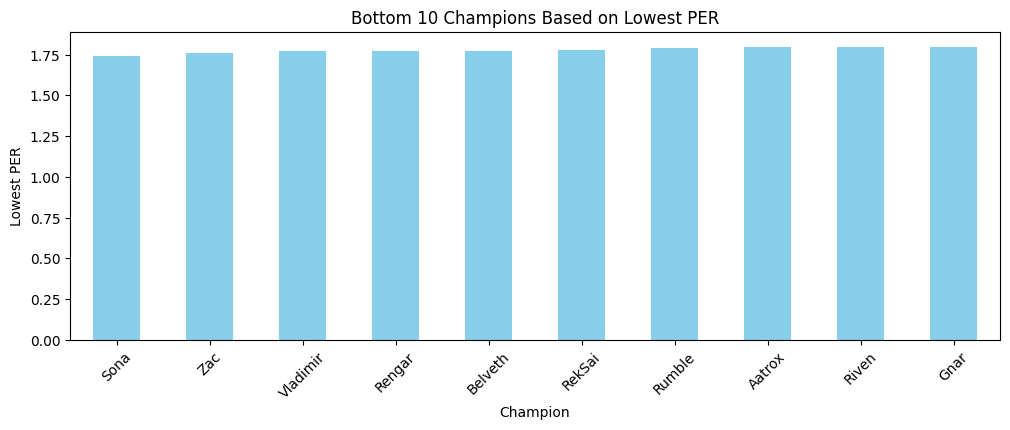

In [126]:
# Identify the lowest 'per' value for each champion
lowest_per_by_champion = df_per.groupby('championName')['per'].min().sort_values().head(10)

# Create a bar chart for the lowest 'per' of the bottom 10 champions
fig, ax = plt.subplots(figsize=(12, 4))
lowest_per_by_champion.plot(kind='bar', color='skyblue', ax=ax)

ax.set_title('Bottom 10 Champions Based on Lowest PER')
ax.set_xlabel('Champion')
ax.set_ylabel('Lowest PER')
plt.xticks(rotation=45)
plt.show();

## 5.6 Top 10 champion PER time series analysis

This analysis presents the time series visualizations of the top 10 champions in League of Legends based on their performance efficiency rating (per) per minute. The per metric is a comprehensive measure of a champion's effectiveness in the game, capturing various aspects of gameplay performance.

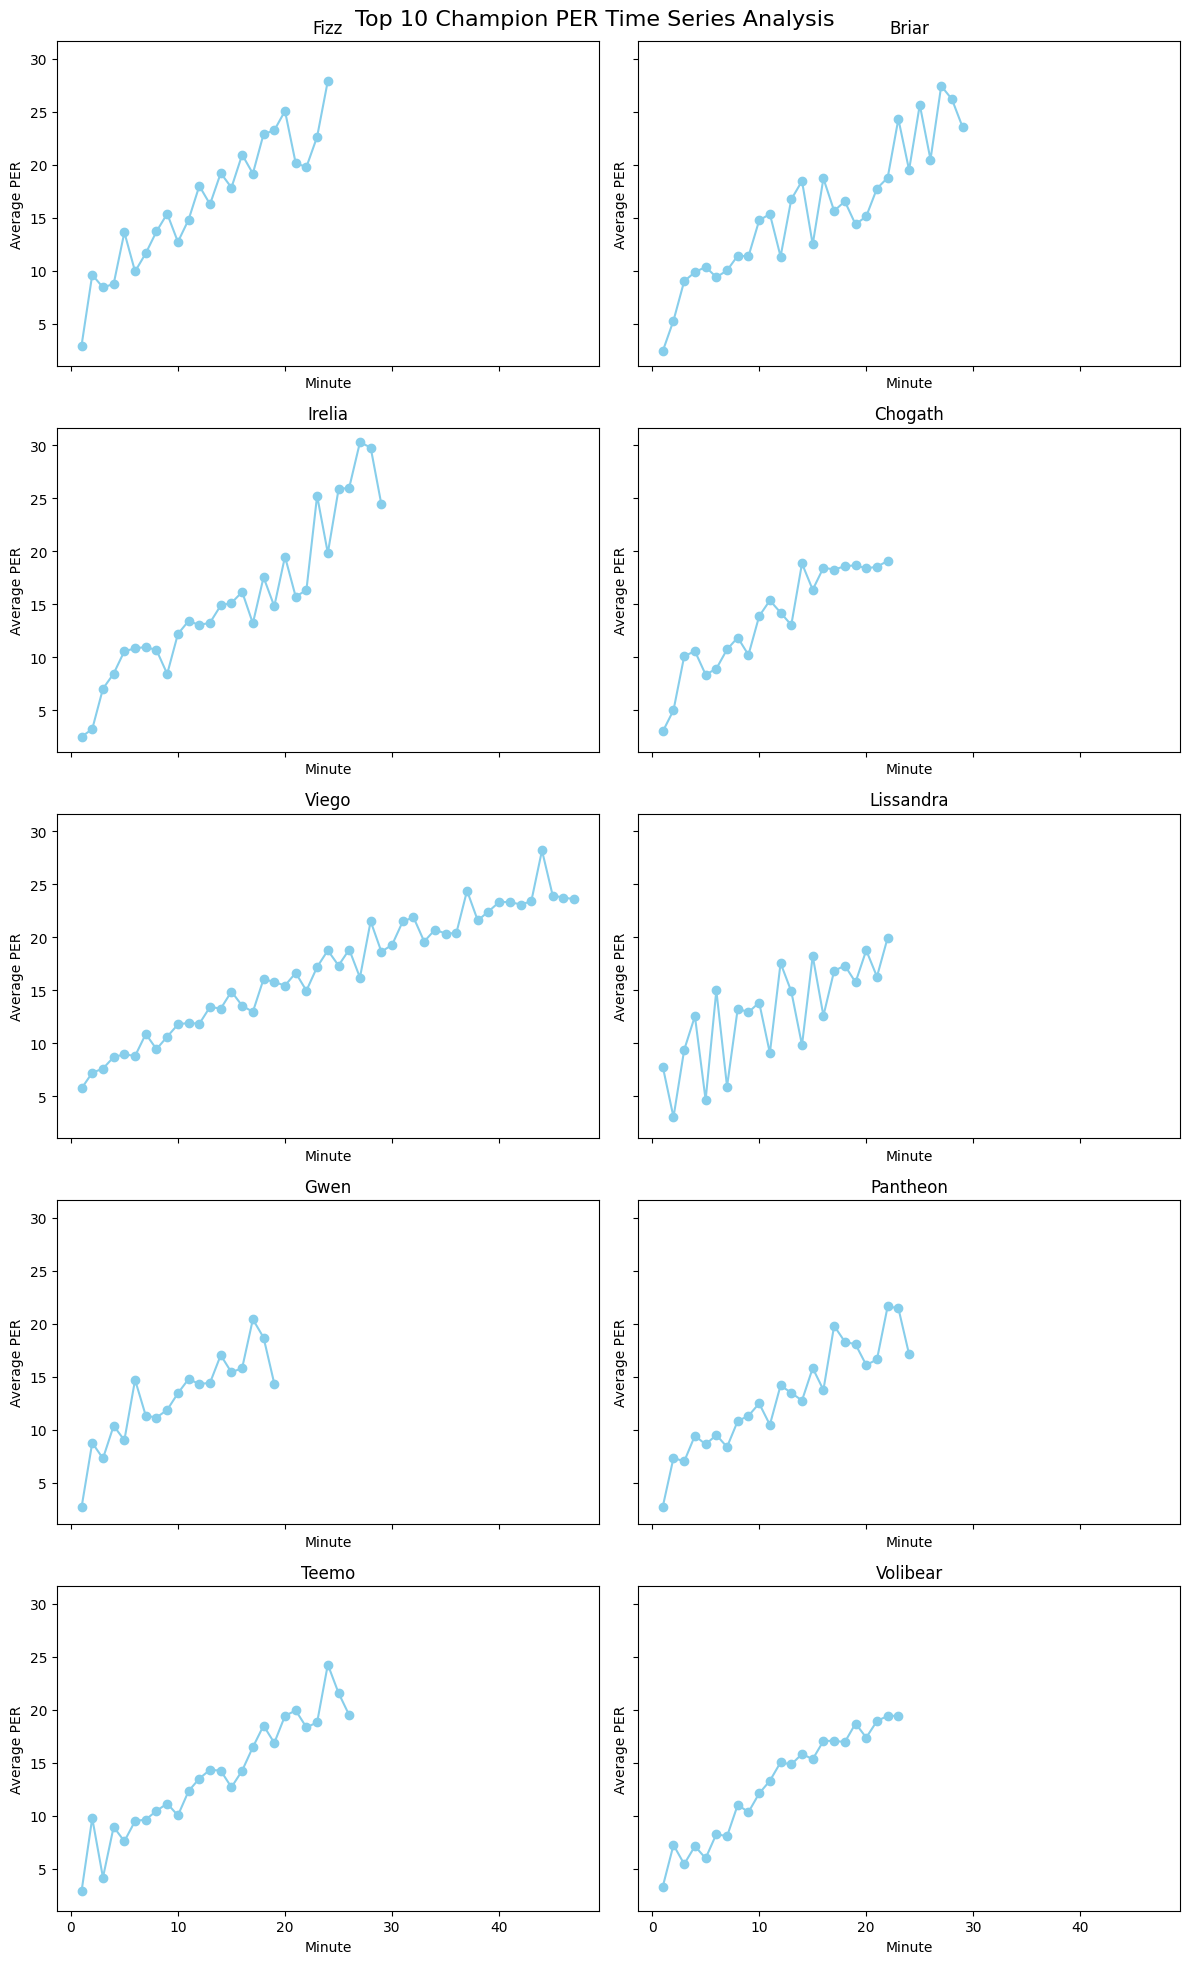

In [127]:
# Plot time series for each top 10 champion
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20), sharex=True, sharey=True)
axes = axes.flatten()

for idx, champion in enumerate(top_10_champions):
    champion_data = top_10_data[top_10_data['championName'] == champion]
    champion_avg_per_minute = champion_data.groupby('minute')['per'].mean()
    
    axes[idx].plot(champion_avg_per_minute.index, champion_avg_per_minute.values, marker='o', color='skyblue')
    axes[idx].set_title(champion)
    axes[idx].set_xlabel('Minute')
    axes[idx].set_ylabel('Average PER')

fig.suptitle('Top 10 Champion PER Time Series Analysis', fontsize=16)
plt.tight_layout()
plt.show();

Interpretations:
- The visualizations illustrate how the per metric evolves over the duration of a match for each of the top 10 champions: Fizz, Briar, Chogath, Pantheon, Irelia, Lissandra, Gwen, Viego, Teemo, and Kalista. By examining these plots, we can observe trends, patterns, and significant moments in the gameplay where these champions excel or face challenges.

## 5.7 Top 10 player average PER 

In [128]:
# Function to fetch summoner names based on PUUIDs using Riot API
def fetch_summoner_names(puuids):
    summoner_names = {}
    base_url = f"https://{MATCH_REGION}.api.riotgames.com/riot/account/v1/accounts/by-puuid/"
    
    for puuid in puuids:
        response = requests.get(f"{base_url}{puuid}?api_key={API_KEY}")
        if response.status_code == 200:
            summoner_data = response.json()
            summoner_names[puuid] = summoner_data['gameName']
        else:
            raise ValueError(f"Failed to fetch summoner name for PUUID: {puuid}, status code: {response.status_code}")
    
    return summoner_names

In [129]:
# Calculate the average PER for each player
average_per_by_player = df_per.groupby('puuid')['per'].mean().sort_values(ascending=False).head(10)
top_10_players = average_per_by_player.index.tolist()

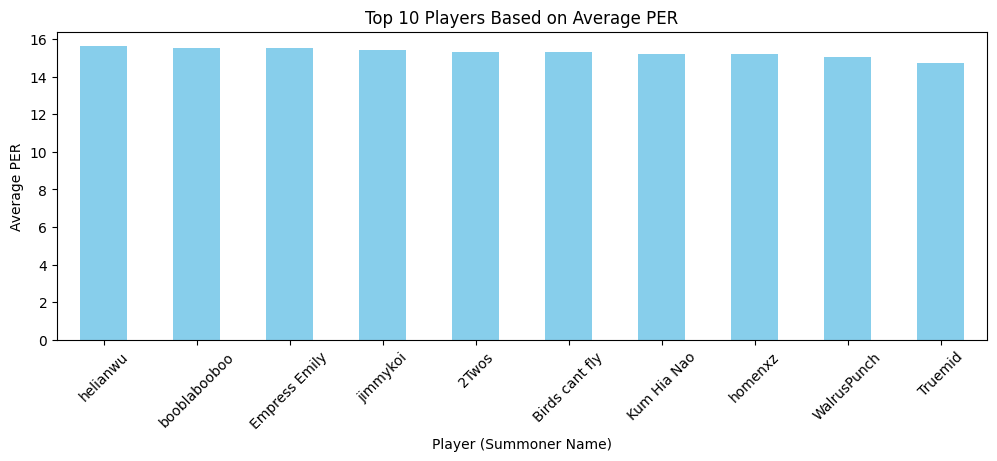

In [130]:
# Fetch the summoner names for each of the top 10 players
summoner_names = fetch_summoner_names(top_10_players)

# Replace PUUIDs with summoner names in the index
average_per_by_player.index = average_per_by_player.index.map(summoner_names)

# Create a bar chart for the average PER of the top 10 players with summoner names
fig, ax = plt.subplots(figsize=(12, 4))
average_per_by_player.plot(kind='bar', color='skyblue', ax=ax)

ax.set_title('Top 10 Players Based on Average PER')
ax.set_xlabel('Player (Summoner Name)')
ax.set_ylabel('Average PER')
plt.xticks(rotation=45)
plt.show();

## 5.8 Top 10 player PER averages over time

C:\Users\josht\AppData\Local\Temp\ipykernel_22520\84757868.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_players_data['summonerName'] = top_10_players_data['puuid'].map(summoner_names)


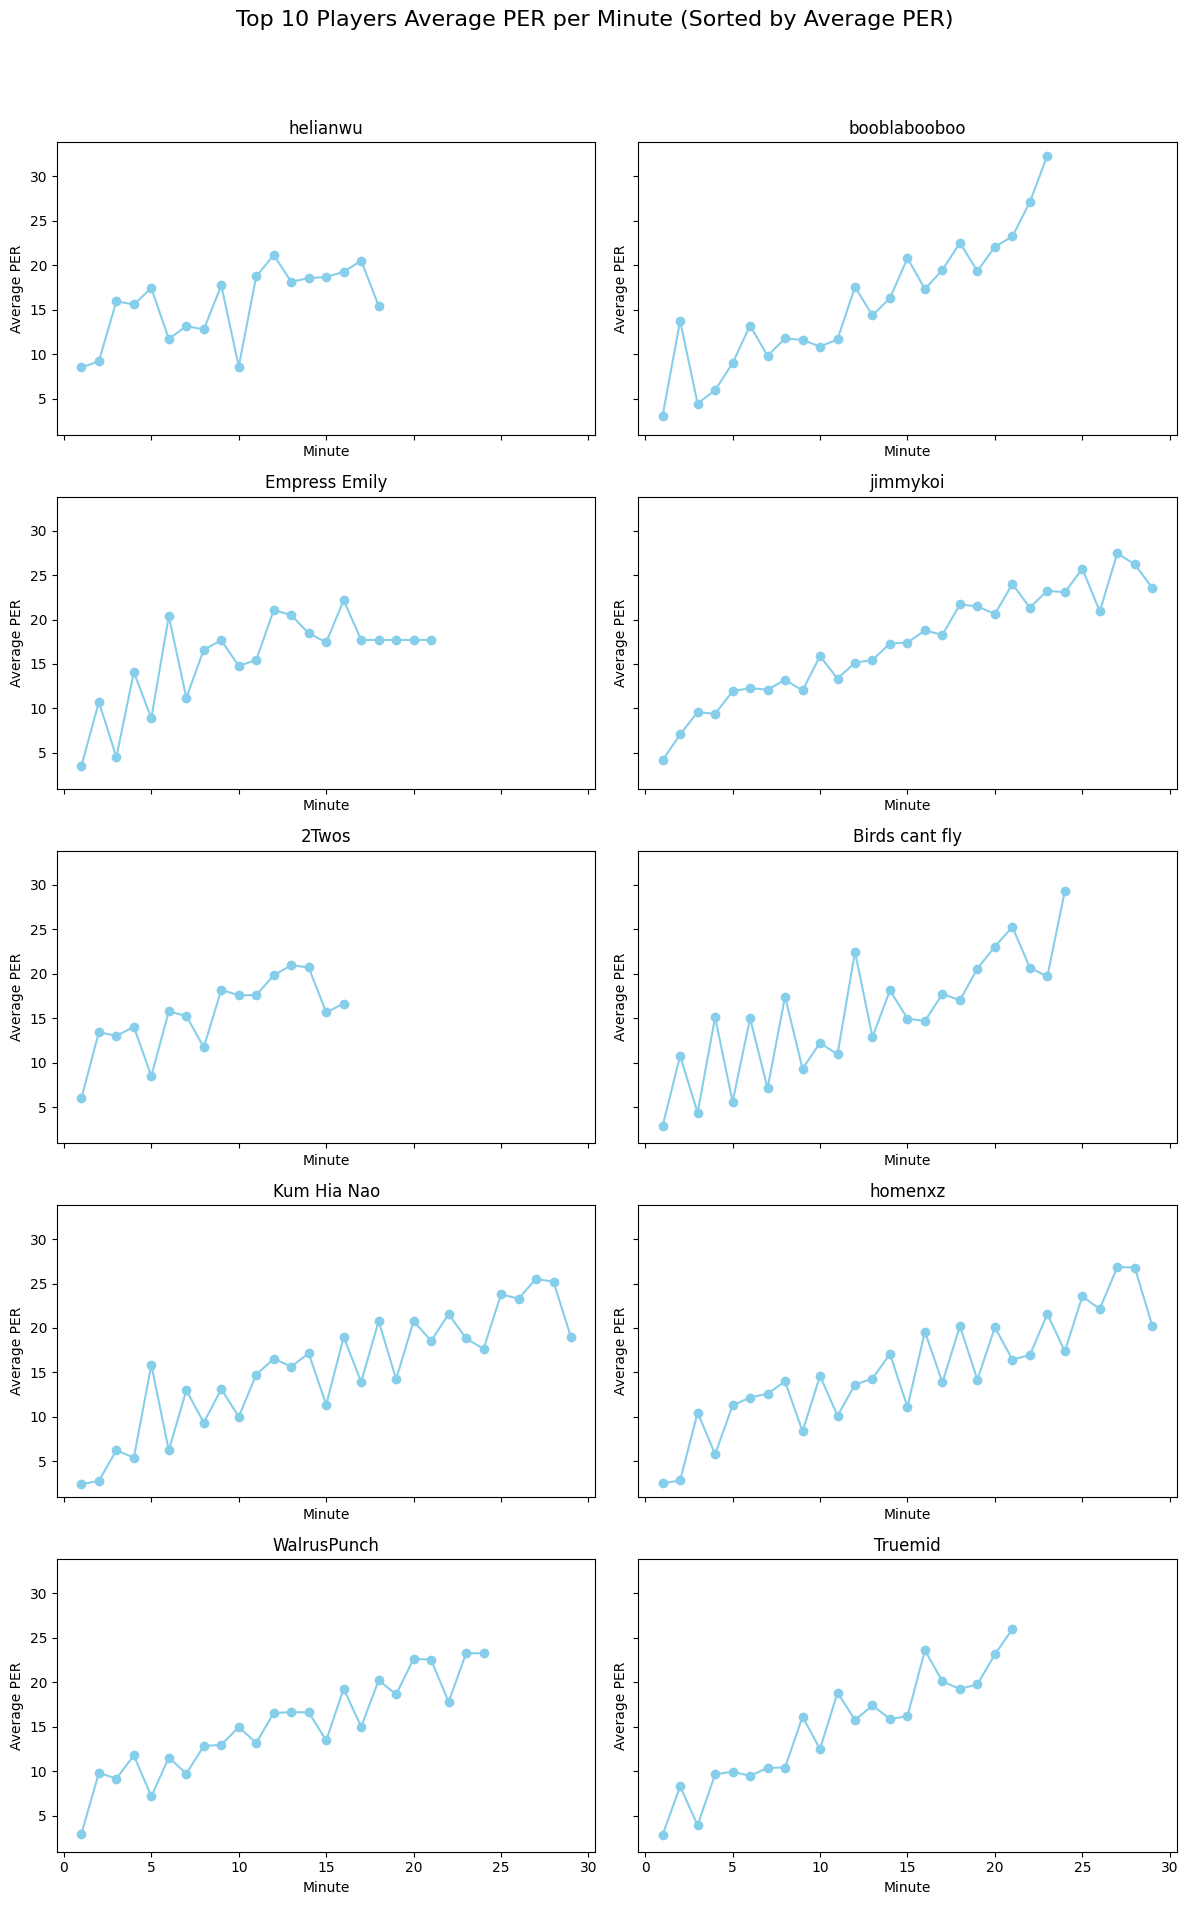

In [67]:
# Filter the data for the top 10 players
top_10_players_data = df_per[df_per['puuid'].isin(top_10_players)]

# Replace PUUIDs with summoner names in the data
top_10_players_data['summonerName'] = top_10_players_data['puuid'].map(summoner_names)

# Calculate the average PER per minute for each player
average_per_per_minute = top_10_players_data.groupby(['summonerName', 'minute'])['per'].mean().unstack()

# Calculate the average PER for each player to sort the plots
average_per_by_player_sorted = top_10_players_data.groupby('summonerName')['per'].mean().sort_values(ascending=False)

# Sort the average PER per minute DataFrame based on the sorted players
average_per_per_minute_sorted = average_per_per_minute.loc[average_per_by_player_sorted.index]

# Create separate line charts for each of the top 10 players sorted by average PER
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20), sharex=True, sharey=True)
axes = axes.flatten()

for idx, player in enumerate(average_per_per_minute_sorted.index):
    axes[idx].plot(average_per_per_minute_sorted.columns, average_per_per_minute_sorted.loc[player], marker='o', color='skyblue')
    axes[idx].set_title(player)
    axes[idx].set_xlabel('Minute')
    axes[idx].set_ylabel('Average PER')

fig.suptitle('Top 10 Players Average PER per Minute (Sorted by Average PER)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show();

Interpretations:
- Players such as jimmykoi and homenxz show steady and consistent increases in PER throughout the match, whereas players such as helianwu and Empress Emily show fluctuations in their performances.
- Empress Emily's average PER flatlines around 17-12 minutes in the match.
- High-performing players show increased levels of PER the longer a match goes on.

# 6. Conclusion <a id='conclusion'></a>

In this notebook, we embarked on a comprehensive journey to analyze and model player performance in League of Legends using data from the Riot Games API. Our process involved several key steps, from data collection and preprocessing to feature extraction and performance evaluation. 

## 6.1 What's next

With the foundation laid in this notebook, several avenues can be explored to extend and deepen the analysis:

### 6.1.1 Model Optimization:

Further fine-tuning of the predictive model can be undertaken to improve accuracy. This includes experimenting with different algorithms, hyperparameters, and feature selection techniques.

### 6.1.2 Advanced Analytics:

Perform advanced statistical analysis and visualizations to uncover deeper insights. This could involve clustering players based on performance metrics, analyzing game phases, or exploring the impact of specific strategies.

### 6.1.3 Real-Time Analytics:

Integrate real-time data feeds to enable live tracking and analysis of ongoing matches. This can provide immediate insights and enable dynamic strategy adjustments.

### 6.1.4 Comparative Analysis:

Conduct comparative analysis between different tiers of players, champions, and game modes. This can help identify unique patterns and strategies employed by top players versus the broader player base.

### 6.1.5 Feature Expansion:

Incorporate additional features such as player communication, item build paths, and map control metrics. These features can enrich the analysis and provide a more holistic view of player and team performance.

### 6.1.6 Dashboard Development:

Develop interactive dashboards to visualize and explore the data dynamically. Dashboards can offer a user-friendly interface for coaches, analysts, and players to interact with the data and derive actionable insights.

### 6.1.7 Web Application Development:

Create a web application that allows users to submit their summoner names and receive their own PER scores. This application would compare their PER with other players, providing personalized insights and benchmarks. Such a tool could enhance player engagement, offering a platform for self-assessment and improvement by highlighting strengths and areas for growth.

By following these next steps, we can build on the insights gained from this notebook and continue to refine our understanding of player performance in League of Legends. This ongoing analysis will contribute to developing more effective strategies, improving player training, and enhancing the overall gameplay experience.